In [ ]:
# Задача 4.1.
# Используя стандартные средства opencv сохраните изображения сгенерированного набора данных в форматах .png, .jpg, .bmp.
# Выполните чтение сохраненных данных из файла.
# При помощи метрик SSIM, MSE сравните данные.
# Задача 4.2.1.
# Реализуйте алгоритмы downsampling:
#  - max
#  - среднее на выбор ( не average)
# Задача 4.2.2.
# Реализуйте алгоритм Ланцоша для восстановления разрешения исходного изображения.
# При помощи метрик SSIM, MSE сравните исходное изображение и восстановленное в исходном разрешении.

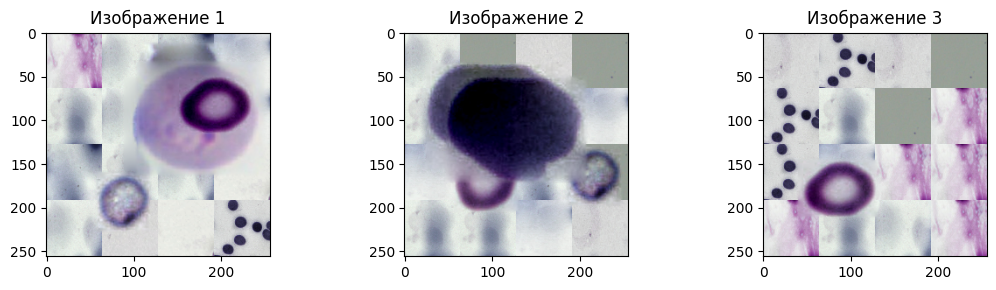


Сравнение изображений
          SSIM       MSE
.png  1.000000  0.000000
.jpg  0.987713  2.338765
.bmp  1.000000  0.000000


In [31]:
#1
import cv2
import numpy as np
import random
import os
from glob import glob
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error
import pandas as pd

# Константы
IMAGE_SIZE = (256, 256)
NUM_CELLS_RANGE = (1, 5)

def create_background_from_patches(image_size=(256, 256), patch_dir="/content/back"):
    """Создает фоновое изображение из патчей."""
    background = np.zeros((image_size[1], image_size[0], 3), dtype=np.uint8)
    patch_size = (64, 64)

    # Загрузка файлов патчей
    patch_files = glob(os.path.join(patch_dir, "*.png"))
    if not patch_files:
        raise FileNotFoundError(f"Не найдены изображения в директории {patch_dir}")

    num_patches_x = image_size[0] // patch_size[0]
    num_patches_y = image_size[1] // patch_size[1]

    # Сборка фона из случайных патчей
    for i in range(num_patches_y):
        for j in range(num_patches_x):
            patch = cv2.imread(random.choice(patch_files), cv2.IMREAD_COLOR)
            if patch is None:
                print(f"Ошибка при загрузке патча из {patch_files[0]}")
                continue
            patch = cv2.resize(patch, patch_size)
            background[
                i * patch_size[1]:(i + 1) * patch_size[1],
                j * patch_size[0]:(j + 1) * patch_size[0]
            ] = patch

    return background

def place_cell(background, cell):
    """Размещает клетку на фоне с использованием seamlessClone."""
    bg_h, bg_w, _ = background.shape
    cell_h, cell_w, _ = cell.shape
    mask = 255 * np.ones((cell_h, cell_w), dtype=np.uint8)
    x = random.randint(0, bg_w - cell_w)
    y = random.randint(0, bg_h - cell_h)
    center = (x + cell_w // 2, y + cell_h // 2)
    background = cv2.seamlessClone(cell, background, mask, center, cv2.NORMAL_CLONE)
    return background

def data_generator(cell_patch_dir="/content/cell", use_generated_circles=True):
    """Генератор изображений с размещением клеток на фоне."""
    while True:
        background = create_background_from_patches()
        clean_image = background.copy()
        num_cells = random.randint(NUM_CELLS_RANGE[0], NUM_CELLS_RANGE[1])
        cell_files = glob(os.path.join(cell_patch_dir, "*.png"))

        for _ in range(num_cells):
            cell = cv2.imread(random.choice(cell_files), cv2.IMREAD_COLOR)
            if cell is None:
                print("Ошибка при загрузке клетки")
                continue

            clean_image = place_cell(clean_image, cell)

        yield clean_image

# Генерация и сохранение изображений
output_dir = "generated_images"
os.makedirs(output_dir, exist_ok=True)

generator = data_generator()
num_images_to_generate = 3
image_formats = [".png", ".jpg", ".bmp"]
generated_images = []

for i in range(num_images_to_generate):
    clean_image = next(generator)
    generated_images.append(clean_image)
    for format in image_formats:
        filename = os.path.join(output_dir, f"clean_image_{i}{format}")
        if format == ".jpg":
            cv2.imwrite(filename, clean_image, [int(cv2.IMWRITE_JPEG_QUALITY), 100])
        else:
            cv2.imwrite(filename, clean_image)

# Визуализация сгенерированных изображений
plt.figure(figsize=(11, 3))
for i, clean_image in enumerate(generated_images):
    plt.subplot(1, num_images_to_generate, i + 1)
    plt.imshow(cv2.cvtColor(clean_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Изображение {i+1}")
plt.tight_layout()
plt.show()

# Сравнение изображений
print("\nСравнение изображений")
results = {format: {"SSIM": [], "MSE": []} for format in image_formats}

for i in range(num_images_to_generate):
    original_image = cv2.imread(os.path.join(output_dir, f"clean_image_{i}.png"))
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    for format in image_formats:
        filename = os.path.join(output_dir, f"clean_image_{i}{format}")
        loaded_image = cv2.imread(filename)
        if loaded_image is None:
            print(f"Ошибка загрузки изображения из {filename}")
            continue
        loaded_image = cv2.cvtColor(loaded_image, cv2.COLOR_BGR2RGB)
        if original_image.shape == loaded_image.shape:
            ssim_score = ssim(original_image, loaded_image, channel_axis=-1, data_range=loaded_image.max() - loaded_image.min())
            mse_score = mean_squared_error(original_image.flatten(), loaded_image.flatten())
        else:
            ssim_score = np.nan
            mse_score = np.nan
        results[format]["SSIM"].append(ssim_score)
        results[format]["MSE"].append(mse_score)

# Создание таблицы результатов
table_data = {
    format: {
        "SSIM": np.nanmean(results[format]["SSIM"]),
        "MSE": np.nanmean(results[format]["MSE"])
    } for format in image_formats
}
df = pd.DataFrame.from_dict(table_data, orient="index")
print(df)

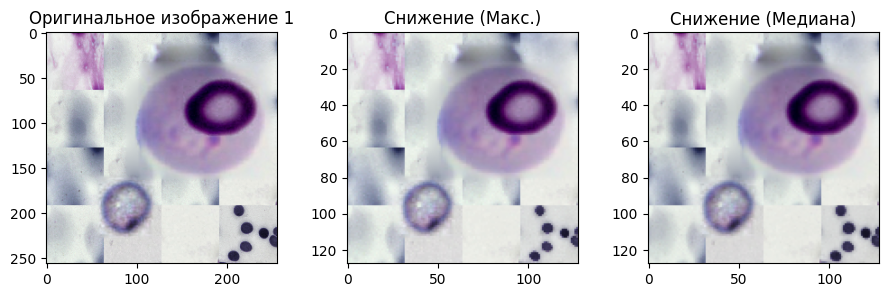

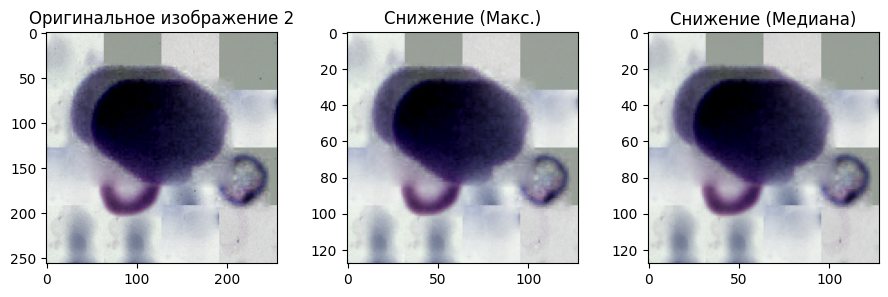

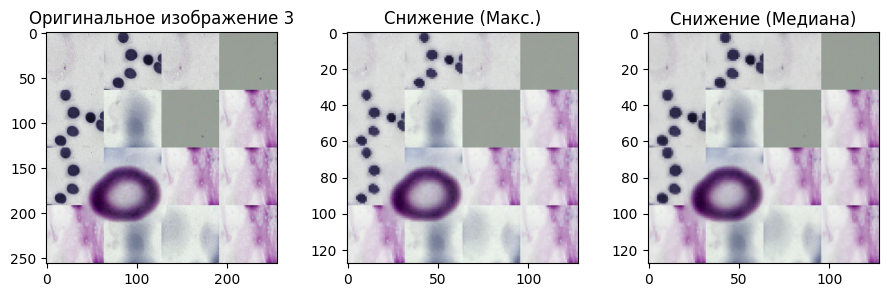

SSIM (Макс.): [np.float64(0.9813823030726313), np.float64(0.9802012579872278), np.float64(0.9732643606601483)]
MSE (Макс.): [33.76812744140625, 19.647216796875, 60.965291341145836]
SSIM (Медиана): [np.float64(0.9968918293852607), np.float64(0.9969560060499812), np.float64(0.9956644190639059)]
MSE (Медиана): [1.2836710611979167, 0.6796875, 2.370849609375]


In [32]:
#2
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error
import os

def downsample_max(image, factor):
    h, w, c = image.shape
    new_h = h // factor
    new_w = w // factor
    downsampled = np.zeros((new_h, new_w, c), dtype=image.dtype)
    for i in range(new_h):
        for j in range(new_w):
            block = image[i * factor:(i + 1) * factor, j * factor:(j + 1) * factor]
            downsampled[i, j] = np.max(block, axis=(0, 1))
    return downsampled.astype(np.uint8)

def downsample_median(image, factor):
    h, w, c = image.shape
    new_h = h // factor
    new_w = w // factor
    downsampled = np.zeros((new_h, new_w, c), dtype=image.dtype)
    for i in range(new_h):
        for j in range(new_w):
            block = image[i * factor:(i + 1) * factor, j * factor:(j + 1) * factor]
            downsampled[i, j] = np.median(block, axis=(0, 1))
    return downsampled.astype(np.uint8)

image_folder = 'generated_images'
image_format = ".png"
downsample_factor = 2
ssim_max_values = []
mse_max_values = []
ssim_median_values = []
mse_median_values = []

num_images = 3

for i in range(num_images):
    image_path = os.path.join(image_folder, f'clean_image_{i}{image_format}')
    original_image = cv2.imread(image_path)
    if original_image is None:
        print(f"Error loading image from {image_path}")
        continue
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    downsampled_max_image = downsample_max(original_image.copy(), downsample_factor)
    downsampled_median_image = downsample_median(original_image.copy(), downsample_factor)

    cv2.imwrite(os.path.join(image_folder, f"clean_image_{i}_downsampled_max{image_format}"), downsampled_max_image)
    cv2.imwrite(os.path.join(image_folder, f"clean_image_{i}_downsampled_median{image_format}"), downsampled_median_image)

    resized_original_image = cv2.resize(original_image, (downsampled_max_image.shape[1], downsampled_max_image.shape[0]), interpolation=cv2.INTER_LINEAR)
    ssim_max = ssim(resized_original_image, downsampled_max_image, channel_axis=-1, data_range=downsampled_max_image.max() - downsampled_max_image.min())
    mse_max = mean_squared_error(resized_original_image.flatten(), downsampled_max_image.flatten())
    ssim_max_values.append(ssim_max)
    mse_max_values.append(mse_max)

    ssim_median = ssim(resized_original_image, downsampled_median_image, channel_axis=-1, data_range=downsampled_median_image.max() - downsampled_median_image.min())
    mse_median = mean_squared_error(resized_original_image.flatten(), downsampled_median_image.flatten())
    ssim_median_values.append(ssim_median)
    mse_median_values.append(mse_median)

    plt.figure(figsize=(11, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title(f"Оригинальное изображение {i+1}")
    plt.subplot(1, 3, 2)
    plt.imshow(downsampled_max_image)
    plt.title("Снижение (Макс.)")
    plt.subplot(1, 3, 3)
    plt.imshow(downsampled_median_image)
    plt.title("Снижение (Медиана)")
    plt.show()

# Вывод метрик
print("SSIM (Макс.):", ssim_max_values)
print("MSE (Макс.):", mse_max_values)
print("SSIM (Медиана):", ssim_median_values)
print("MSE (Медиана):", mse_median_values)

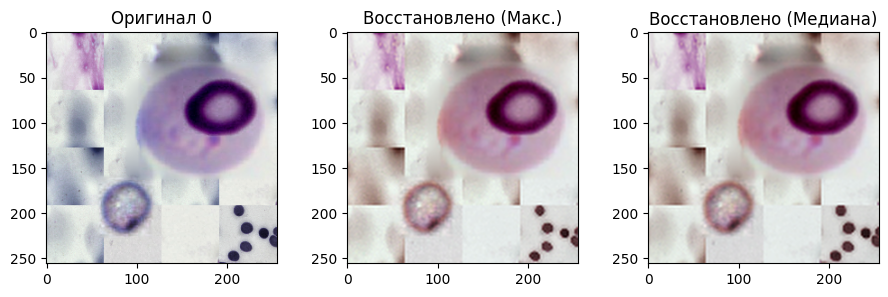

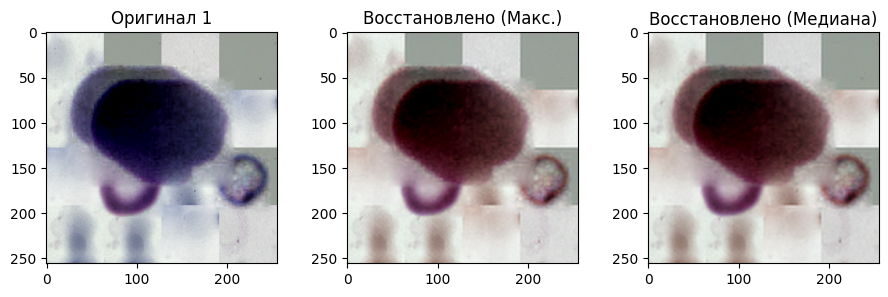

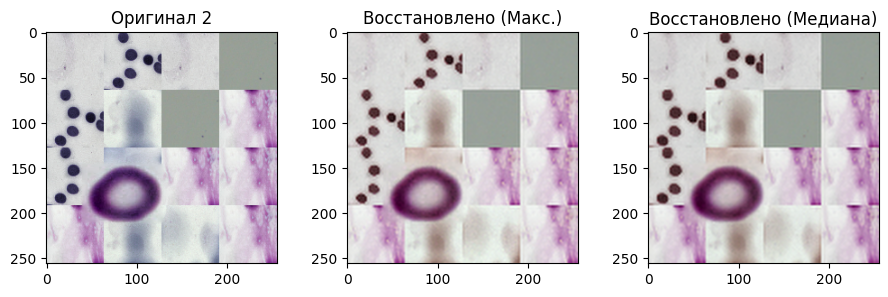

Изображение 1:
SSIM аксимум: 0.8916;   SSIM медианнa: 0.9086;   MSE максимум: 192.82;   MSE медианнa: 161.21
Изображение 2:
SSIM аксимум: 0.8507;   SSIM медианнa: 0.8642;   MSE максимум: 244.66;   MSE медианнa: 222.85
Изображение 3:
SSIM аксимум: 0.8767;   SSIM медианнa: 0.9000;   MSE максимум: 148.15;   MSE медианнa: 89.97


In [38]:
#3
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error
import os

def upscale_lanczos(image, scale=2):
    h, w = image.shape[:2]
    new_h, new_w = h * scale, w * scale
    return cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LANCZOS4)

# параметры
image_folder = 'generated_images'
image_format = ".png"
downsample_factor = 2
num_images = 3

ssim_lanczos_values = []
mse_lanczos_values = []

# обработка изображения
for i in range(num_images):
    image_path_original = os.path.join(image_folder, f'clean_image_{i}{image_format}')
    image_path_max = os.path.join(image_folder, f'clean_image_{i}_downsampled_max{image_format}')
    image_path_median = os.path.join(image_folder, f'clean_image_{i}_downsampled_median{image_format}')

    original_image = cv2.imread(image_path_original)
    downsampled_max_image = cv2.imread(image_path_max)
    downsampled_median_image = cv2.imread(image_path_median)

    if original_image is None or downsampled_max_image is None or downsampled_median_image is None:
        print(f"Ошибка при загрузке изображений для {image_path_original}, {image_path_max} или {image_path_median}")
        continue

    # конвертация
    original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    downsampled_max_image_rgb = cv2.cvtColor(downsampled_max_image, cv2.COLOR_BGR2RGB)
    downsampled_median_image_rgb = cv2.cvtColor(downsampled_median_image, cv2.COLOR_BGR2RGB)

    # масштабирование изображения с помощью Ланцоша
    upscaled_max_image = upscale_lanczos(downsampled_max_image_rgb, scale=downsample_factor)
    upscaled_median_image = upscale_lanczos(downsampled_median_image_rgb, scale=downsample_factor)

    # восстановление
    resized_original_max = cv2.resize(original_image_rgb, (upscaled_max_image.shape[1], upscaled_max_image.shape[0]), interpolation=cv2.INTER_LINEAR)
    resized_original_median = cv2.resize(original_image_rgb, (upscaled_median_image.shape[1], upscaled_median_image.shape[0]), interpolation=cv2.INTER_LINEAR)

    # расчет SSIM и MSE для изображения с max downsampling
    ssim_max = ssim(resized_original_max, upscaled_max_image, channel_axis=-1, data_range=upscaled_max_image.max() - upscaled_max_image.min())
    mse_max = mean_squared_error(resized_original_max.flatten(), upscaled_max_image.flatten())

    # расчет SSIM и MSE для изображения с median downsampling
    ssim_median = ssim(resized_original_median, upscaled_median_image, channel_axis=-1, data_range=upscaled_median_image.max() - upscaled_median_image.min())
    mse_median = mean_squared_error(resized_original_median.flatten(), upscaled_median_image.flatten())

    ssim_lanczos_values.append((ssim_max, ssim_median))
    mse_lanczos_values.append((mse_max, mse_median))

    plt.figure(figsize=(11, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(original_image_rgb)
    plt.title(f"Оригинал {i}")

    plt.subplot(1, 3, 2)
    plt.imshow(upscaled_max_image)
    plt.title("Восстановлено (Макс.)")

    plt.subplot(1, 3, 3)
    plt.imshow(upscaled_median_image)
    plt.title("Восстановлено (Медиана)")

    plt.show()

for i in range(num_images):
    ssim_max, ssim_median = ssim_lanczos_values[i]
    mse_max, mse_median = mse_lanczos_values[i]

    print(f"Изображение {i+1}:")
    print(f"SSIM аксимум: {ssim_max:.4f};  ", f"SSIM медианнa: {ssim_median:.4f};  ",f"MSE максимум: {mse_max:.2f};  ",f"MSE медианнa: {mse_median:.2f}")